In [1]:
import warnings

from keras.datasets import fashion_mnist
from keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import keras
import matplotlib.pyplot as plt
import numpy as np

# warnings.filterwarnings('ignore')
%matplotlib inline


Using TensorFlow backend.


In [2]:
# Some constants
IMG_ROWS = 28
IMG_COLS = 28
NUM_CLASSES = 10
TEST_SIZE = 0.2
RANDOM_STATE = 2018

#Model
NUM_EPOCHS = 10
BATCH_SIZE = 128

In [3]:
# Auxiliar functions
def plot_imgs(img_batch):
    # Plot the sample images now
    f, ax = plt.subplots(4, 4, figsize=(10, 10))
    for i, img in enumerate(img_batch):
        img = img.reshape(28, 28)
        ax[i//4, i%4].imshow(img, cmap='gray')
        ax[i//4, i%4].axis('off')
    plt.show()    


def data_preprocessing(x_data, y_data):
    x_data = x_data.astype('float32')
    out_y = to_categorical(y_data, len(np.unique(y_data)))
    out_x = np.expand_dims(x_data, axis=-1)
    
    return out_x, out_y

def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['acc']
    val_acc = hist['val_acc']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()


In [4]:
# load data
(x_train_data, y_train_data), (x_test_data, y_test_data) = fashion_mnist.load_data()

# prepare the data
X, y = data_preprocessing(x_train_data, y_train_data)
X_test, y_test = data_preprocessing(x_test_data, y_test_data)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

## Feature Standardization

It is possible to standardize pixel values across the entire dataset. This is called feature standardization and mirrors the type of standardization often performed for each column in a tabular dataset.

You can perform feature standardization by setting the `featurewise_center` and `featurewise_std_normalization` arguments on the `ImageDataGenerator` class. These are in fact set to True by default and creating an instance of `ImageDataGenerator` with no arguments will have the same effect.


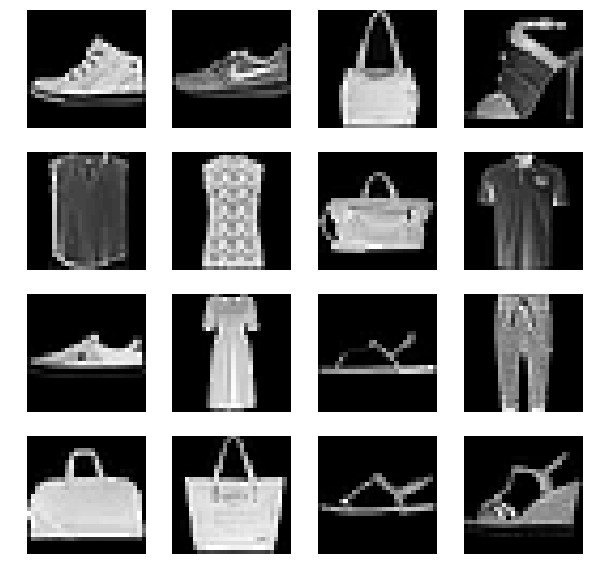

In [5]:
plot_imgs(X_train[:16])

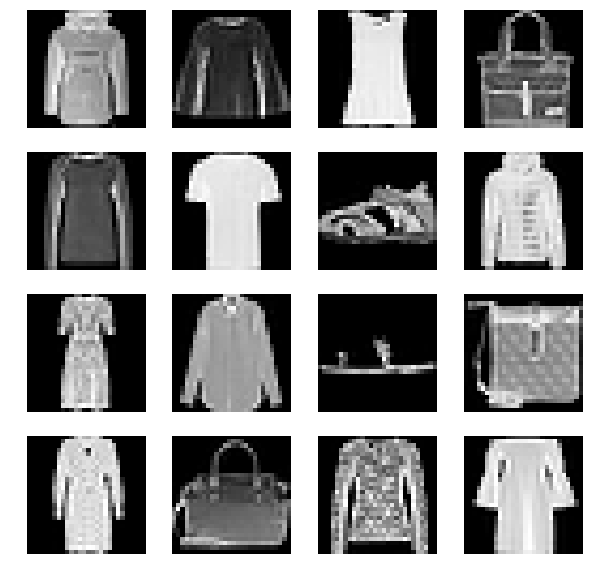

In [6]:
# define data preparation
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
# fit parameters from data
datagen.fit(X_train)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=16):
    plot_imgs(X_batch)
    break

## ZCA Whitening

A whitening transform of an image is a linear algebra operation that reduces the redundancy in the matrix of pixel images.

Less redundancy in the image is intended to better highlight the structures and features in the image to the learning algorithm.

Typically, image whitening is performed using the Principal Component Analysis (PCA) technique. More recently, an alternative called ZCA [1] shows better results and results in transformed images that keeps all of the original dimensions and unlike PCA, resulting transformed images still look like their originals.

You can perform a ZCA whitening transform by setting the zca_whitening argument to True.

/users/mferreyra/.virtualenvs/diplodatos-cv/lib/python3.6/site-packages/keras_preprocessing/image.py:787: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


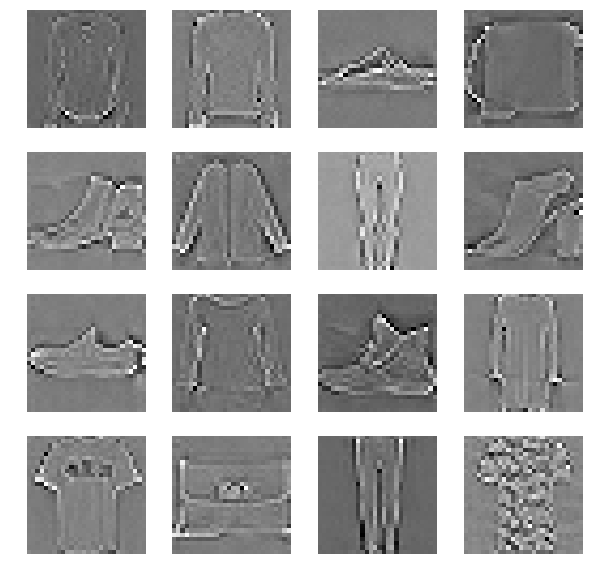

In [7]:
# define data preparation
datagen = ImageDataGenerator(zca_whitening=True)
# fit parameters from data
datagen.fit(X_train)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=16):
    plot_imgs(X_batch)
    break

## Random Rotations

Sometimes images in your sample data may have varying and different rotations in the scene.

You can train your model to better handle rotations of images by artificially and randomly rotating images from your dataset during training.

The example below creates random rotations of the data up to 90 degrees by setting the rotation_range argument.

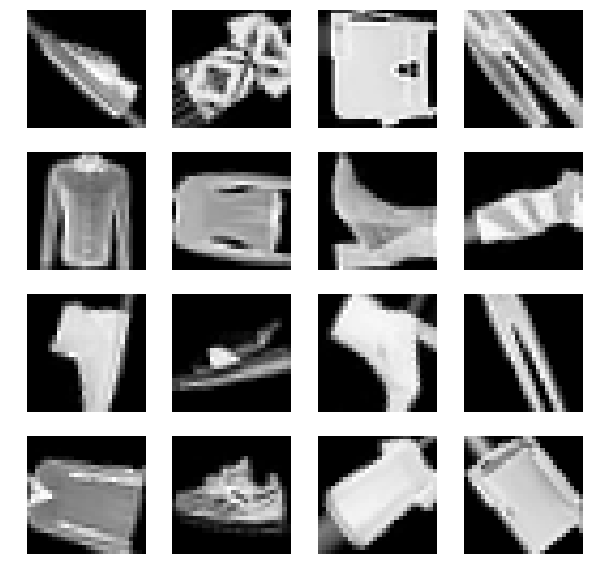

In [8]:
# define data preparation
datagen = ImageDataGenerator(rotation_range=90)

# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=16):
    plot_imgs(X_batch)
    break

## Random Shifts

Objects in your images may not be centered in the frame. They may be off-center in a variety of different ways.

You can train your deep learning network to expect and currently handle off-center objects by artificially creating shifted versions of your training data. Keras supports separate horizontal and vertical random shifting of training data by the width_shift_range and height_shift_range arguments.


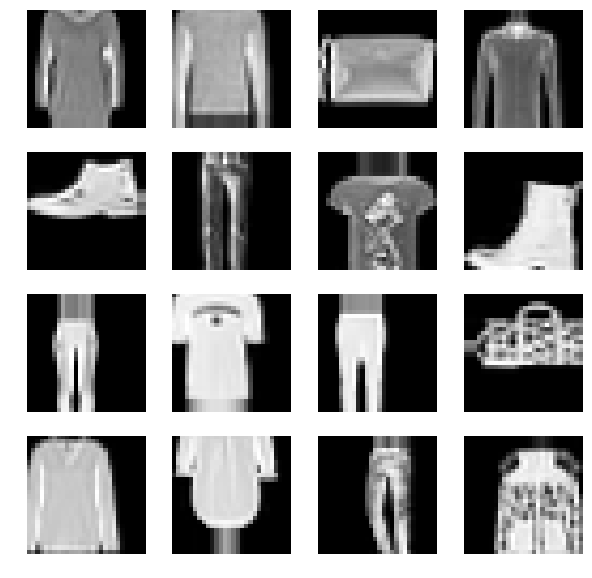

In [9]:
# define data preparation
shift = 0.2
datagen = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)

# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=16):
    plot_imgs(X_batch)
    break

## Random Flips

Another augmentation to your image data that can improve performance on large and complex problems is to create random flips of images in your training data.

Keras supports random flipping along both the vertical and horizontal axes using the vertical_flip and horizontal_flip arguments.

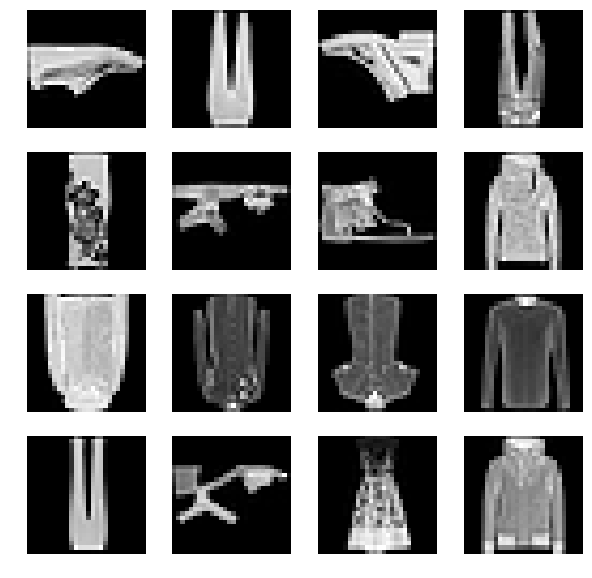

In [10]:
# define data preparation
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)

# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=16):
    plot_imgs(X_batch)
    break

## Add a custom preprocessing function

You can also add your own preprocessing function.
The function should take one argument: one image (Numpy tensor with rank 3, e.g. `shape=(N, M, K)`), and should output a Numpy tensor with the same shape.


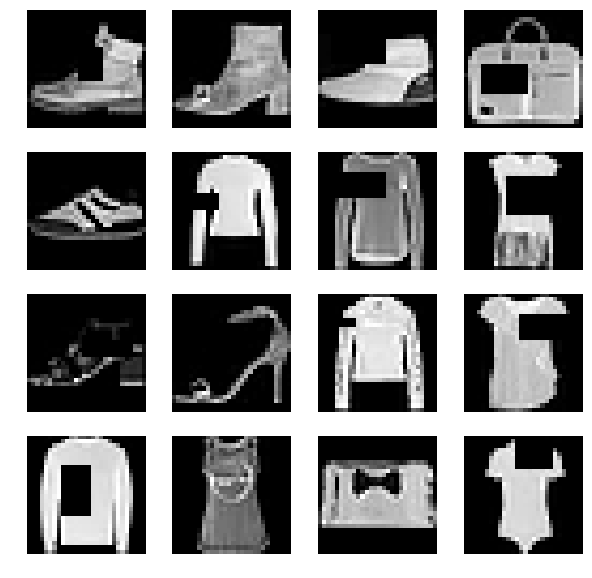

In [11]:
def random_occlusion(img):
    h = IMG_ROWS // 2
    w = IMG_COLS // 2
    y1 = np.random.randint(h)
    y2 = min(y1 + np.random.randint(h), IMG_ROWS)
    x1 = np.random.randint(w)
    x2 = min(x1 + np.random.randint(w), IMG_COLS)
   
    img[y1:y2, x1:x2, :] = 0.
    
    return img

# define data preparation
datagen = ImageDataGenerator(preprocessing_function=random_occlusion)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=16):
    plot_imgs(X_batch)
    break


## Saving Augmented Images to File

The data preparation and augmentation is performed just in time by Keras.

This is efficient in terms of memory, but you may require the exact images used during training. For example, perhaps you would like to use them with a different software package later or only generate them once and use them on multiple different deep learning models or configurations.

Keras allows you to save the images generated during training. The directory, filename prefix and image file type can be specified to the flow() function before training. Then, during training, the generated images will be written to file.

The example below demonstrates this and writes 16 images to a “aug_images” subdirectory with the prefix “aug” and the file type of PNG.


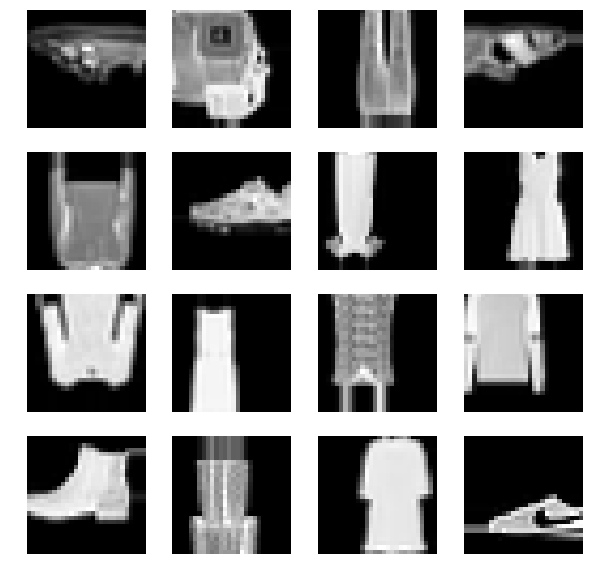

In [12]:
# define data preparation
shift = 0.2
datagen = ImageDataGenerator(
    width_shift_range=shift, 
    height_shift_range=shift,
    horizontal_flip=True, 
    vertical_flip=True
)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, 
                                     batch_size=16, save_to_dir='aug_images', 
                                     save_prefix='aug', save_format='png'):
    plot_imgs(X_batch)
    break
    

# Train with data augmentation on-the-fly

## Create model

In [13]:
# Model
model = Sequential()
# Add convolution 2D
model.add(Conv2D(
    16,
    kernel_size=(3, 3),
    activation='relu',
    kernel_initializer='he_normal',
    input_shape=(IMG_ROWS, IMG_COLS, 1)
))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(
    32, 
    kernel_size=(3, 3), 
    activation='relu'
))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(
    64,
    (3, 3),
    activation='relu'
))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy']
)

## Train with data augmentation

We have to set two `ImageDataGenerator` objects. One for `training` images and another for `validation` images.


In [14]:
# Training data generator
datagen_train = ImageDataGenerator(
    rescale=1./255,  # We also can make a rescale on the data
    horizontal_flip=True,
    rotation_range = 60,
    width_shift_range=0.2,
    height_shift_range=0.2
)

# Validation data generator
datagen_val = ImageDataGenerator(rescale=1./255)

# Train!
train_model = model.fit_generator(
    datagen_train.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=NUM_EPOCHS,
    validation_data=datagen_val.flow(X_val, y_val, batch_size=BATCH_SIZE),
    steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
    validation_steps=X_val.shape[0] // BATCH_SIZE
)

Epoch 1/10
375/375 [==============================] - 14s 38ms/step - loss: 1.4550 - acc: 0.4705 - val_loss: 1.0793 - val_acc: 0.6253
Epoch 2/10
375/375 [==============================] - 14s 37ms/step - loss: 1.0748 - acc: 0.6110 - val_loss: 0.9156 - val_acc: 0.6583
Epoch 3/10
375/375 [==============================] - 14s 37ms/step - loss: 0.9434 - acc: 0.6566 - val_loss: 0.7704 - val_acc: 0.7171
Epoch 4/10
375/375 [==============================] - 14s 37ms/step - loss: 0.8714 - acc: 0.6832 - val_loss: 0.7569 - val_acc: 0.7205
Epoch 5/10
375/375 [==============================] - 14s 37ms/step - loss: 0.8302 - acc: 0.6968 - val_loss: 0.7540 - val_acc: 0.7228
Epoch 6/10
375/375 [==============================] - 14s 37ms/step - loss: 0.7871 - acc: 0.7122 - val_loss: 0.7066 - val_acc: 0.7312
Epoch 7/10
375/375 [==============================] - 14s 37ms/step - loss: 0.7563 - acc: 0.7238 - val_loss: 0.8006 - val_acc: 0.7107
Epoch 8/10
375/375 [==============================] - 14s 37ms

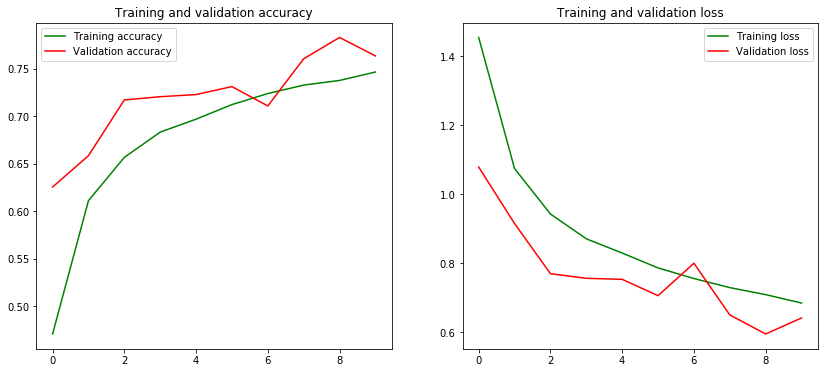

In [15]:
plot_accuracy_and_loss(train_model)

In [16]:
score = model.evaluate(X_test / 255., y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6468707199573517
Test accuracy: 0.7665


# References

Original source: https://machinelearningmastery.com/image-augmentation-deep-learning-keras/

Keras official documentation: https://keras.io/preprocessing/image/#imagedatagenerator-class

[1] Learning Multiple Layers of Features from Tiny Images, http://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf